In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve,fbeta_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegressionCV
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate  
from scipy import stats
from sklearn.inspection import permutation_importance




# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

# 设置numpy随机种子
np.random.seed(42)


c:\data\minicoda\envs\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('外呼建模-0708.parquet')
#查看 df 的基本信息
#了解数据的整体情况
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578982 entries, 0 to 578981
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   加密手机号码          578982 non-null  object        
 1   市场确认是否意向        578982 non-null  int64         
 2   是否转化成交          578982 non-null  int64         
 3   资源渠道            578982 non-null  object        
 4   是否接触过卓越         578982 non-null  int64         
 5   是否领过资料          578982 non-null  int64         
 6   首次成交日期_TMS      139 non-null     datetime64[ns]
 7   首次成交金额_TMS      2598 non-null    float64       
 8   首次购买科目_TMS      134 non-null     object        
 9   首次购买科数_TMS      134 non-null     float64       
 10  首次成交日期_EVIP     10 non-null      datetime64[ns]
 11  首次成交金额_EVIP     446 non-null     float64       
 12  首次购买科目_EVIP     9 non-null       object        
 13  首次购买科数_EVIP     446 non-null     float64       
 14  拨打次数            578982 non-null  int

In [41]:
deal = df[df['是否转化成交']==1]
deal = deal[deal['打通次数'] >= 1]
deal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 1782 to 575926
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   加密手机号码          143 non-null    object        
 1   市场确认是否意向        143 non-null    int64         
 2   是否转化成交          143 non-null    int64         
 3   资源渠道            143 non-null    object        
 4   是否接触过卓越         143 non-null    int64         
 5   是否领过资料          143 non-null    int64         
 6   首次成交日期_TMS      133 non-null    datetime64[ns]
 7   首次成交金额_TMS      133 non-null    float64       
 8   首次购买科目_TMS      129 non-null    object        
 9   首次购买科数_TMS      129 non-null    float64       
 10  首次成交日期_EVIP     10 non-null     datetime64[ns]
 11  首次成交金额_EVIP     11 non-null     float64       
 12  首次购买科目_EVIP     9 non-null      object        
 13  首次购买科数_EVIP     11 non-null     float64       
 14  拨打次数            143 non-null    int64         
 15  打通次数 

In [42]:
filtered_df = df[df['市场确认是否意向'] == 1]
filtered_df = filtered_df[filtered_df['是否转化成交'] == 0]
filtered_df = filtered_df[filtered_df['打通次数'] >= 1]
undeal = filtered_df
undeal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2812 entries, 279 to 578521
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   加密手机号码          2812 non-null   object        
 1   市场确认是否意向        2812 non-null   int64         
 2   是否转化成交          2812 non-null   int64         
 3   资源渠道            2812 non-null   object        
 4   是否接触过卓越         2812 non-null   int64         
 5   是否领过资料          2812 non-null   int64         
 6   首次成交日期_TMS      0 non-null      datetime64[ns]
 7   首次成交金额_TMS      2403 non-null   float64       
 8   首次购买科目_TMS      0 non-null      object        
 9   首次购买科数_TMS      0 non-null      float64       
 10  首次成交日期_EVIP     0 non-null      datetime64[ns]
 11  首次成交金额_EVIP     423 non-null    float64       
 12  首次购买科目_EVIP     0 non-null      object        
 13  首次购买科数_EVIP     423 non-null    float64       
 14  拨打次数            2812 non-null   int64         
 15  打通次数 

In [ ]:

print("有意向未转化通话活动类型:")
活动效果 = filtered_df['long_通话活动名称'].value_counts().head(8)
for 活动, 数量 in 活动效果.items():
    print(f"  {活动}: {数量}人 ({数量/len(filtered_df)*100:.1f}%)")

未转化通话活动类型:
  【悦学广州分校】3-12邀约新初一（强校真题集）: 299人 (10.6%)
  【悦学广州分校】4-10新初一fbk真题集: 255人 (9.1%)
  【悦学广州分校】2月14号邀约成长素养体验课: 248人 (8.8%)
  4-19志愿填报见面会: 219人 (7.8%)
  【悦学广州分校】4-14期末真题集（简化版）: 218人 (7.8%)
  【悦学广州分校】3-11信息大挑战（采集年级）: 127人 (4.5%)
  【悦学广州分校】2月8号邀约个辅体验课: 124人 (4.4%)
  【悦学广州分校】3月9号邀约信息大挑战（tmk资源池））: 94人 (3.3%)


In [44]:
# 先查看数据实际字段
print("原始数据字段:")
print(f"总字段数: {len(df.columns)}")
print("字段列表:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

print(f"\n成交客户数据形状: {deal.shape}")
print(f"未成交有意向客户数据形状: {undeal.shape}")

# 检查数据样本
print("\n成交客户数据样本:")
print(deal.head(2))

print("\n未成交有意向客户数据样本:")
print(undeal.head(2))


原始数据字段:
总字段数: 41
字段列表:
 1. 加密手机号码
 2. 市场确认是否意向
 3. 是否转化成交
 4. 资源渠道
 5. 是否接触过卓越
 6. 是否领过资料
 7. 首次成交日期_TMS
 8. 首次成交金额_TMS
 9. 首次购买科目_TMS
10. 首次购买科数_TMS
11. 首次成交日期_EVIP
12. 首次成交金额_EVIP
13. 首次购买科目_EVIP
14. 首次购买科数_EVIP
15. 拨打次数
16. 打通次数
17. 利益点完播次数
18. 活动通知次数
19. 通话15-30s次数
20. 通话30-60s次数
21. 通话60s以上次数
22. long_通话日期
23. long_通话时长
24. long_呼叫时段
25. long_是否工作日
26. long_周几
27. long_通话活动名称
28. long_客户意向_AI
29. long_客户意向_人工
30. long_号码归属地
31. latest_通话日期
32. latest_通话时长
33. latest_呼叫时段
34. latest_是否工作日
35. latest_周几
36. latest_通话活动名称
37. latest_客户意向_AI
38. latest_客户意向_人工
39. 客户属性文本汇总
40. 首次呼叫时间
41. 首次打通时间

成交客户数据形状: (143, 41)
未成交有意向客户数据形状: (2812, 41)

成交客户数据样本:
                                加密手机号码  市场确认是否意向  是否转化成交    资源渠道  是否接触过卓越  \
1782  5964c0e2fbd266f7569687182fd226dd         1       1   外部白名单        0   
3112  5a04fb632a5743cf0be4dc0ff816cf29         1       1  成长沉睡激活        1   

      是否领过资料          首次成交日期_TMS  首次成交金额_TMS 首次购买科目_TMS  首次购买科数_TMS  ...  \
1782       0 2025-03-19 20:33:22

In [45]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义要排除的字段（不具有分析意义的字段）
EXCLUDED_FIELDS = [
    '市场确认是否意向',    # 筛选条件，成交客户全为1
    '是否转化成交',       # 目标变量
    '是否接触过卓越',     # 基本都是1，区分度低
    '是否领过资料',       # 基本都是1，区分度低
    '首次成交金额_TMS',   # 成交结果，不是原因
    '首次成交金额_EVIP',  # 成交结果，不是原因
    '首次购买科数_EVIP',  # 成交结果，不是原因
    '首次购买科数_TMS',   # 成交结果，不是原因
]

# 筛选数值型字段进行分析
def analyze_numerical_fields():
    print("=== 数值型字段分析 ===\n")
    
    # 获取数值型字段
    numerical_cols = []
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            # 排除ID字段和不具有分析意义的字段
            if ('id' not in col.lower() and '编号' not in col and 
                col not in EXCLUDED_FIELDS):
                numerical_cols.append(col)
    
    print(f"发现的数值型字段 ({len(numerical_cols)}个):")
    for i, col in enumerate(numerical_cols):
        print(f"{i+1:2d}. {col}")
        
    return numerical_cols

# 分析分类字段
def analyze_categorical_fields():
    print("\n=== 分类字段分析 ===\n")
    
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            # 排除文本描述字段和不具有分析意义的字段
            if ('文本' not in col and '备注' not in col and '描述' not in col and 
                col not in EXCLUDED_FIELDS):
                categorical_cols.append(col)
    
    print(f"发现的分类字段 ({len(categorical_cols)}个):")
    for i, col in enumerate(categorical_cols):
        unique_count = df[col].nunique()
        print(f"{i+1:2d}. {col} (唯一值: {unique_count})")
        
    return categorical_cols

numerical_fields = analyze_numerical_fields()
categorical_fields = analyze_categorical_fields()


=== 数值型字段分析 ===

发现的数值型字段 (9个):
 1. 拨打次数
 2. 打通次数
 3. 利益点完播次数
 4. 活动通知次数
 5. 通话15-30s次数
 6. 通话30-60s次数
 7. 通话60s以上次数
 8. long_通话时长
 9. latest_通话时长

=== 分类字段分析 ===

发现的分类字段 (17个):
 1. 加密手机号码 (唯一值: 578982)
 2. 资源渠道 (唯一值: 12)
 3. 首次购买科目_TMS (唯一值: 23)
 4. 首次购买科目_EVIP (唯一值: 7)
 5. long_呼叫时段 (唯一值: 9)
 6. long_是否工作日 (唯一值: 2)
 7. long_周几 (唯一值: 7)
 8. long_通话活动名称 (唯一值: 55)
 9. long_客户意向_AI (唯一值: 26)
10. long_客户意向_人工 (唯一值: 26)
11. long_号码归属地 (唯一值: 323)
12. latest_呼叫时段 (唯一值: 9)
13. latest_是否工作日 (唯一值: 2)
14. latest_周几 (唯一值: 7)
15. latest_通话活动名称 (唯一值: 55)
16. latest_客户意向_AI (唯一值: 28)
17. latest_客户意向_人工 (唯一值: 28)


=== 数值特征对比分析 ===

           字段名   成交客户均值  成交客户中位数  未成交客户均值  未成交客户中位数    均值差异   差异率(%)    T统计量  \
0         拨打次数   3.9161      3.0   4.0882       3.0 -0.1721  -4.2099 -0.5709   
1         打通次数   1.8811      2.0   1.7916       2.0  0.0895   4.9962  1.1239   
2      利益点完播次数   1.5455      1.0   1.4015       1.0  0.1440  10.2720  2.1959   
3       活动通知次数   2.2448      2.0   2.2952       2.0 -0.0504  -2.1963 -0.4831   
4   通话15-30s次数   0.3916      0.0   0.3314       0.0  0.0602  18.1548  1.2394   
5   通话30-60s次数   0.7762      1.0   0.7717       1.0  0.0045   0.5872  0.0785   
6    通话60s以上次数   0.3566      0.0   0.2706       0.0  0.0860  31.7846  2.1292   
7    long_通话时长  51.0559     50.0  50.1348      49.0  0.9212   1.8374  0.4149   
8  latest_通话时长  37.3077     37.0  37.9132      38.0 -0.6055  -1.5972 -0.2453   

       P值 显著性  
0  0.5681      
1  0.2611      
2  0.0282   *  
3  0.6291      
4  0.2153      
5  0.9374      
6  0.0333   *  
7  0.6782      
8  0.8062      

发现 2 个具有显著差异的字段:
- 利

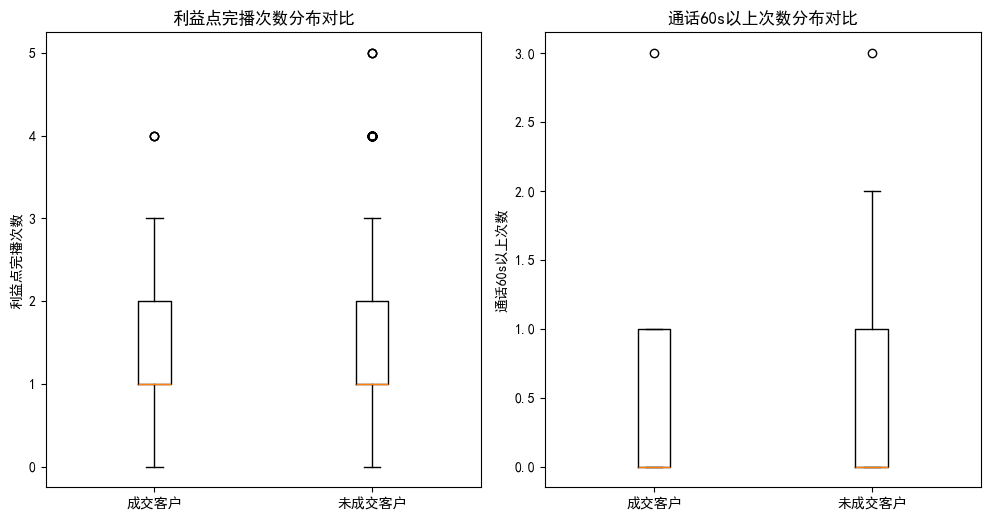

In [46]:
# 基于实际字段的数值特征对比分析
def compare_numerical_features(numerical_fields):
    print("=== 数值特征对比分析 ===\n")
    
    results = []
    valid_fields = []
    
    for field in numerical_fields:
        if field in deal.columns and field in undeal.columns:
            # 计算基本统计量
            deal_data = deal[field].dropna()
            undeal_data = undeal[field].dropna()
            
            if len(deal_data) > 0 and len(undeal_data) > 0:
                # 进行t检验
                try:
                    t_stat, p_value = stats.ttest_ind(deal_data, undeal_data)
                    
                    results.append({
                        '字段名': field,
                        '成交客户均值': deal_data.mean(),
                        '成交客户中位数': deal_data.median(),
                        '未成交客户均值': undeal_data.mean(),
                        '未成交客户中位数': undeal_data.median(),
                        '均值差异': deal_data.mean() - undeal_data.mean(),
                        '差异率(%)': ((deal_data.mean() - undeal_data.mean()) / undeal_data.mean() * 100) if undeal_data.mean() != 0 else 0,
                        'T统计量': t_stat,
                        'P值': p_value,
                        '显著性': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
                    })
                    valid_fields.append(field)
                except:
                    pass
    
    if results:
        comparison_df = pd.DataFrame(results)
        comparison_df = comparison_df.round(4)
        print(comparison_df)
        
        # 可视化显著差异的字段
        significant_fields = [field for field, p in zip(valid_fields, comparison_df['P值']) if p < 0.05]
        
        if significant_fields:
            print(f"\n发现 {len(significant_fields)} 个具有显著差异的字段:")
            for field in significant_fields:
                print(f"- {field}")
            
            # 可视化前8个显著字段
            n_plots = min(8, len(significant_fields))
            if n_plots > 0:
                fig, axes = plt.subplots(2, 4, figsize=(20, 10))
                axes = axes.flatten()
                
                for i, field in enumerate(significant_fields[:n_plots]):
                    deal_data = deal[field].dropna()
                    undeal_data = undeal[field].dropna()
                    
                    axes[i].boxplot([deal_data, undeal_data], labels=['成交客户', '未成交客户'])
                    axes[i].set_title(f'{field}分布对比')
                    axes[i].set_ylabel(field)
                
                # 删除多余的子图
                for j in range(n_plots, len(axes)):
                    fig.delaxes(axes[j])
                
                plt.tight_layout()
                plt.show()
        
        return comparison_df
    else:
        print("没有可分析的数值字段")
        return None

if numerical_fields:
    numerical_comparison = compare_numerical_features(numerical_fields)
else:
    print("没有发现数值型字段")


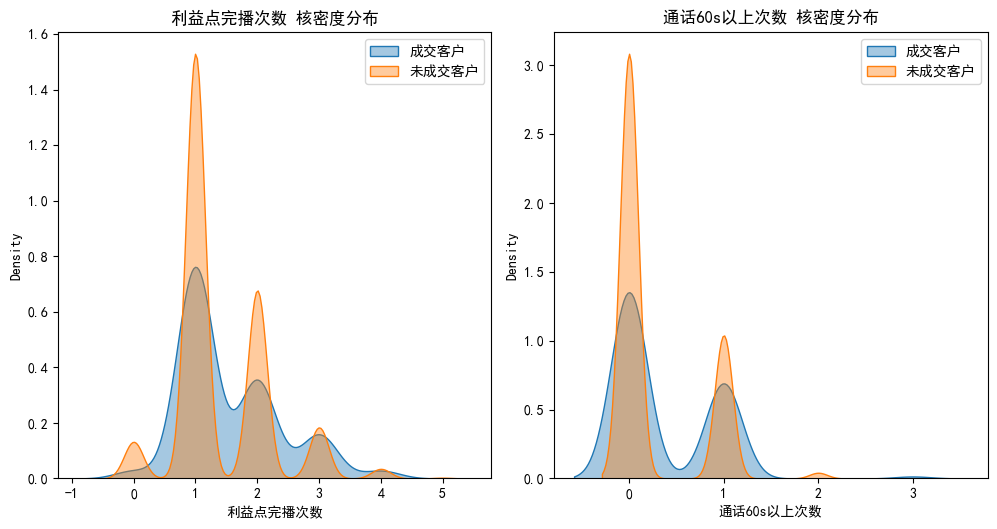

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_for_significant_fields(deal, undeal, significant_fields):
    """
    绘制显著差异字段的核密度图
    """
    n_plots = min(8, len(significant_fields))
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, field in enumerate(significant_fields[:n_plots]):
        deal_data = deal[field].dropna()
        undeal_data = undeal[field].dropna()
        
        # 核密度图
        sns.kdeplot(deal_data, label='成交客户', ax=axes[i], fill=True, alpha=0.4)
        sns.kdeplot(undeal_data, label='未成交客户', ax=axes[i], fill=True, alpha=0.4)
        
        axes[i].set_title(f'{field} 核密度分布')
        axes[i].legend()
    
    # 删除多余子图
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# 调用示例
if 'numerical_comparison' in locals():
    significant_fields = numerical_comparison.loc[numerical_comparison['P值'] < 0.05, '字段名'].tolist()
    if significant_fields:
        plot_density_for_significant_fields(deal, undeal, significant_fields)


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# === Cliff's Delta ===
def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    more = sum(x > y for x in a for y in b)
    less = sum(x < y for x in a for y in b)
    return (more - less) / (n1 * n2)

# === 单字段差异分析 ===
def compare_groups(a, b, n_bootstrap=1000):
    a = np.array(a.dropna())
    b = np.array(b.dropna())
    
    # 基本统计
    mean_diff = a.mean() - b.mean()
    cohen_d = mean_diff / np.sqrt(((a.std(ddof=1)**2 + b.std(ddof=1)**2)/2))
    cliff_d = cliffs_delta(a, b)
    
    # 统计检验
    t_stat, t_p = stats.ttest_ind(a, b, equal_var=False)
    u_stat, u_p = stats.mannwhitneyu(a, b, alternative='two-sided')
    ks_stat, ks_p = stats.ks_2samp(a, b)
    
    # Bootstrap 均值差置信区间
    boot_diffs = [
        np.mean(np.random.choice(a, len(a), replace=True)) -
        np.mean(np.random.choice(b, len(b), replace=True))
        for _ in range(n_bootstrap)
    ]
    ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
    
    return {
        "Group1_n": len(a),
        "Group2_n": len(b),
        "Mean_diff": mean_diff,
        "Cohen_d": cohen_d,
        "Cliff_delta": cliff_d,
        "Welch_t_p": t_p,
        "MannWhitneyU_p": u_p,
        "KS_p": ks_p,
        "Bootstrap_CI": (ci_low, ci_high)
    }

# === 批量分析 ===
all_results = []

for field in numerical_fields:
    if field in deal.columns and field in undeal.columns:
        res = compare_groups(deal[field], undeal[field])
        res["Field"] = field
        all_results.append(res)

result_df = pd.DataFrame(all_results)

# 重新排序列
result_df = result_df[['Field','Group1_n','Group2_n','Mean_diff','Cohen_d','Cliff_delta',
                       'Welch_t_p','MannWhitneyU_p','KS_p','Bootstrap_CI']]


# === 增加显著性等级列（基于 MannWhitneyU_p 检验 p 值）===
def significance_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

result_df['Significance'] = result_df['MannWhitneyU_p'].apply(significance_marker)

# 排序：按MannWhitneyU_p检验 p 值
result_df = result_df.sort_values("MannWhitneyU_p").reset_index(drop=True)

for col in ['Mean_diff', 'Cohen_d', 'Cliff_delta', 'Welch_t_p', 'MannWhitneyU_p', 'KS_p']:
    result_df[col] = result_df[col].astype(float).round(5)

# 2️⃣ 精简 Bootstrap_CI
result_df['Bootstrap_CI'] = result_df['Bootstrap_CI'].apply(lambda x: f"({x[0]:.5f}, {x[1]:.5f})")





# 显示
pd.set_option('display.max_colwidth', None)
display(result_df)


,Field,Group1_n,Group2_n,Mean_diff,Cohen_d,Cliff_delta,Welch_t_p,MannWhitneyU_p,KS_p,Bootstrap_CI,Significance
0,通话60s以上次数,143,2812,0.08602,0.17328,0.08105,0.05563,0.03228,0.29249,"(0.00292, 0.18634)",*
1,利益点完播次数,143,2812,0.14396,0.18288,0.08543,0.03955,0.04907,0.79012,"(0.00932, 0.27334)",*
2,打通次数,143,2812,0.08951,0.09481,0.05333,0.27783,0.24426,0.88243,"(-0.07244, 0.25548)",
3,通话15-30s次数,143,2812,0.06017,0.10182,0.04439,0.25518,0.25686,0.96372,"(-0.03801, 0.17030)",
4,long_通话时长,143,2812,0.92116,0.04009,0.05003,0.58487,0.31217,0.27552,"(-2.22865, 4.27162)",
5,拨打次数,143,2812,-0.17211,-0.04971,-0.02118,0.55656,0.66441,0.62895,"(-0.72849, 0.43656)",
6,通话30-60s次数,143,2812,0.00453,0.00687,0.01055,0.93482,0.81206,1.00000,"(-0.10150, 0.12226)",
7,latest_通话时长,143,2812,-0.60554,-0.02274,0.00490,0.77139,0.92118,0.98083,"(-4.77194, 3.77816)",
8,活动通知次数,143,2812,-0.05041,-0.04342,-0.00445,0.59438,0.92579,0.99222,"(-0.23508, 0.13355)",


In [49]:
print(result_df)

         Field  Group1_n  Group2_n  Mean_diff  Cohen_d  Cliff_delta  \
0    通话60s以上次数       143      2812    0.08602  0.17328      0.08105   
1      利益点完播次数       143      2812    0.14396  0.18288      0.08543   
2         打通次数       143      2812    0.08951  0.09481      0.05333   
3   通话15-30s次数       143      2812    0.06017  0.10182      0.04439   
4    long_通话时长       143      2812    0.92116  0.04009      0.05003   
5         拨打次数       143      2812   -0.17211 -0.04971     -0.02118   
6   通话30-60s次数       143      2812    0.00453  0.00687      0.01055   
7  latest_通话时长       143      2812   -0.60554 -0.02274      0.00490   
8       活动通知次数       143      2812   -0.05041 -0.04342     -0.00445   

   Welch_t_p  MannWhitneyU_p     KS_p         Bootstrap_CI Significance  
0    0.05563         0.03228  0.29249   (0.00292, 0.18634)            *  
1    0.03955         0.04907  0.79012   (0.00932, 0.27334)            *  
2    0.27783         0.24426  0.88243  (-0.07244, 0.25548)         

由于是一个零膨胀的案例

因此使用 

将零膨胀数据拆解为两个过程：

是否为 0 → 用 比例差异检验（卡方检验或 Fisher 精确检验）

直接比较两组“零占比”是否显著不同

非零部分大小差异 → 用 非参数检验（Mann-Whitney U / permutation test）

只在非零数据上比较分布差异

最后整合：

如果零占比显著不同 → 差异主要在“有/无行为”

如果非零差异显著 → 差异主要在“活跃用户的强度”

零膨胀回归
如果想直接检验两组均值/分布差异，同时控制零膨胀：

Zero-Inflated Poisson (ZIP)
适合稀疏计数且方差≈均值

Zero-Inflated Negative Binomial (ZINB)
适合过度离散（方差≫均值）


In [50]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.discrete.count_model as cm

# === Cliff's Delta ===
def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    more = sum(x > y for x in a for y in b)
    less = sum(x < y for x in a for y in b)
    return (more - less) / (n1 * n2)

# === 零膨胀差异分析函数 ===
def zero_inflated_compare(a, b, do_zinb=True):
    """返回零比例p、非零p、可选ZINB整体p"""
    a = np.array(a.dropna())
    b = np.array(b.dropna())

    # 1️⃣ 零比例差异（Fisher精确检验）
    zero_a = (a == 0).sum()
    zero_b = (b == 0).sum()
    table = np.array([
        [zero_a, len(a) - zero_a],
        [zero_b, len(b) - zero_b]
    ])
    _, p_zero = stats.fisher_exact(table)

    # 2️⃣ 非零部分强度（Mann-Whitney U）
    nz_a = a[a > 0]
    nz_b = b[b > 0]
    if len(nz_a) > 0 and len(nz_b) > 0:
        _, p_nonzero = stats.mannwhitneyu(nz_a, nz_b, alternative='two-sided')
    else:
        p_nonzero = np.nan

    # 3️⃣ ZINB整体拟合
    p_zinb = np.nan
    if do_zinb and len(a) > 0 and len(b) > 0:
        try:
            df_tmp = pd.DataFrame({
                'y': np.concatenate([a, b]),
                'group': np.array([0]*len(a) + [1]*len(b))
            })
            model = cm.ZeroInflatedNegativeBinomialP(
                endog=df_tmp['y'],
                exog=sm.add_constant(df_tmp['group']),
                exog_infl=sm.add_constant(df_tmp['group']),
                inflation='logit'
            )
            res = model.fit(disp=False)
            p_zinb = res.pvalues[1]  # group系数p值
        except:
            p_zinb = np.nan

    return p_zero, p_nonzero, p_zinb

# === 显著性标注函数 ===
def significance_marker(p):
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# === 主分析函数 ===
def zero_inflated_effect_analysis(deal, undeal, numerical_fields, do_zinb=True):
    all_results = []

    for field in numerical_fields:
        if field in deal.columns and field in undeal.columns:
            a = deal[field].dropna()
            b = undeal[field].dropna()
            if len(a) == 0 or len(b) == 0:
                continue

            # 计算效应量
            mean_diff = a.mean() - b.mean()
            pooled_std = np.sqrt(((a.std(ddof=1)**2 + b.std(ddof=1)**2) / 2))
            cohen_d = mean_diff / pooled_std if pooled_std > 0 else np.nan
            cliff_d = cliffs_delta(a, b)

            # 零膨胀检验
            p_zero, p_nonzero, p_zinb = zero_inflated_compare(a, b, do_zinb)

            all_results.append({
                "Field": field,
                "Group1_n": len(a),
                "Group2_n": len(b),
                "Mean_diff": mean_diff,
                "Cohen_d": cohen_d,
                "Cliff_delta": cliff_d,
                "Zero_p": p_zero,
                "Zero_sig": significance_marker(p_zero),
                "NonZero_p": p_nonzero,
                "NonZero_sig": significance_marker(p_nonzero),
                "ZINB_p": p_zinb,
                "ZINB_sig": significance_marker(p_zinb)
            })

    result_df = pd.DataFrame(all_results)

    # 排序：按ZINB整体显著性
    result_df = result_df.sort_values("ZINB_p").reset_index(drop=True)

    # 保留数值精度
    for col in ['Mean_diff', 'Cohen_d', 'Cliff_delta', 'Zero_p', 'NonZero_p', 'ZINB_p']:
        result_df[col] = result_df[col].astype(float).round(6)

    return result_df

# === 调用示例 ===
result_df = zero_inflated_effect_analysis(deal, undeal, numerical_fields, do_zinb=True)
pd.set_option('display.max_colwidth', None)
display(result_df)


,Field,Group1_n,Group2_n,Mean_diff,Cohen_d,Cliff_delta,Zero_p,Zero_sig,NonZero_p,NonZero_sig,ZINB_p,ZINB_sig
0,long_通话时长,143,2812,0.921165,0.040088,0.050025,1.000000,,0.312167,,0.995606,
1,拨打次数,143,2812,-0.172110,-0.049708,-0.021180,1.000000,,0.664412,,NaN,
2,打通次数,143,2812,0.089511,0.094814,0.053333,1.000000,,0.244262,,NaN,
3,利益点完播次数,143,2812,0.143961,0.182881,0.085426,0.115767,,0.167580,,NaN,
4,活动通知次数,143,2812,-0.050408,-0.043416,-0.004446,1.000000,,0.925790,,NaN,
5,通话15-30s次数,143,2812,0.060172,0.101819,0.044388,0.298381,,0.587750,,NaN,
6,通话30-60s次数,143,2812,0.004531,0.006872,0.010552,0.719981,,0.627965,,NaN,
7,通话60s以上次数,143,2812,0.086017,0.173281,0.081054,0.032307,*,0.515800,,NaN,
8,latest_通话时长,143,2812,-0.605537,-0.022742,0.004897,1.000000,,0.956117,,NaN,


In [51]:
print(result_df)

         Field  Group1_n  Group2_n  Mean_diff   Cohen_d  Cliff_delta  \
0    long_通话时长       143      2812   0.921165  0.040088     0.050025   
1         拨打次数       143      2812  -0.172110 -0.049708    -0.021180   
2         打通次数       143      2812   0.089511  0.094814     0.053333   
3      利益点完播次数       143      2812   0.143961  0.182881     0.085426   
4       活动通知次数       143      2812  -0.050408 -0.043416    -0.004446   
5   通话15-30s次数       143      2812   0.060172  0.101819     0.044388   
6   通话30-60s次数       143      2812   0.004531  0.006872     0.010552   
7    通话60s以上次数       143      2812   0.086017  0.173281     0.081054   
8  latest_通话时长       143      2812  -0.605537 -0.022742     0.004897   

     Zero_p Zero_sig  NonZero_p NonZero_sig    ZINB_p ZINB_sig  
0  1.000000            0.312167              0.995606           
1  1.000000            0.664412                   NaN           
2  1.000000            0.244262                   NaN           
3  0.115767        

成交客户 ≈ 未成交客户 在大多数呼叫行为上分布相似

唯一区别在于：
成交客户更容易有一次长通话（>60s），但总体差异仍然弱效应

实际建模意义：

这些单字段无法显著区分客户转化

需要组合特征（如通话数量 + 通话时长 + 完播次数）构造综合指标

解释了为什么后面要组合特征

可进一步用零膨胀模型或树模型提取非线性特征

In [ ]:
#对转化和有意向未转化的到此结束

In [ ]:
#对全量数据的查看

===== 成交客户周几 × 呼叫时段数量表 =====


,long_周几,long_呼叫时段,成交数
0,周一,15点,2
1,周一,16点,4
2,周一,17点,4
3,周一,19点,20
4,周三,15点,2
5,周三,16点,3
6,周三,17点,2
7,周三,19点,13
8,周二,11点之前,3
9,周二,17点,2


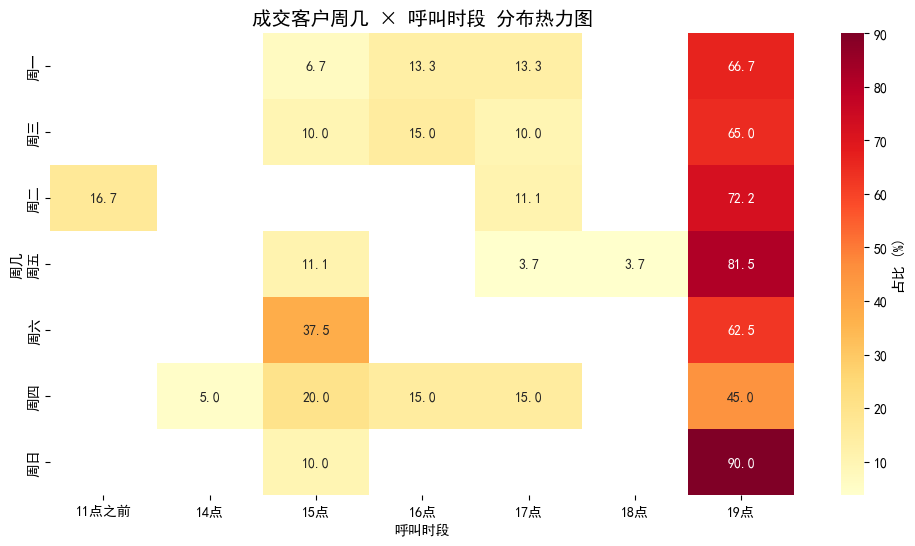

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ 只取成交客户数据
deal_df = df.copy()
deal_df= deal_df[ deal_df['是否转化成交'] == 1]
# 2️⃣ 计算数量表
count_table = (
    deal_df.groupby(['long_周几','long_呼叫时段'])
    .size()
    .reset_index(name='成交数')
)

print("===== 成交客户周几 × 呼叫时段数量表 =====")
display(count_table)

# 3️⃣ 计算百分比表（周几内归一化）
total_per_weekday = (
    deal_df.groupby(['long_周几','long_呼叫时段'])
    .size()
    .groupby(level=0)
    .transform('sum')  # 每个周几的总成交数
)

percent_df = (
    deal_df.groupby(['long_周几','long_呼叫时段'])
    .size()
    / total_per_weekday * 100
).reset_index(name='百分比')

# 4️⃣ 透视表用于热力图
heatmap_pivot = percent_df.pivot(index='long_周几', columns='long_呼叫时段', values='百分比')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label':'占比 (%)'})
plt.title("成交客户周几 × 呼叫时段 分布热力图", fontsize=14)
plt.ylabel("周几")
plt.xlabel("呼叫时段")
plt.show()


=== 外呼接触变量与转化的关系分析 ===

拨打次数:
  转化客户平均值: 3.92
  未转化客户平均值: 3.87
  差异: 0.05

打通次数:
  转化客户平均值: 1.81
  未转化客户平均值: 0.75
  差异: 1.06

利益点完播次数:
  转化客户平均值: 1.48
  未转化客户平均值: 0.28
  差异: 1.20

活动通知次数:
  转化客户平均值: 2.22
  未转化客户平均值: 1.90
  差异: 0.32

通话15-30s次数:
  转化客户平均值: 0.38
  未转化客户平均值: 0.17
  差异: 0.20

通话30-60s次数:
  转化客户平均值: 0.74
  未转化客户平均值: 0.08
  差异: 0.67

通话60s以上次数:
  转化客户平均值: 0.34
  未转化客户平均值: 0.01
  差异: 0.33


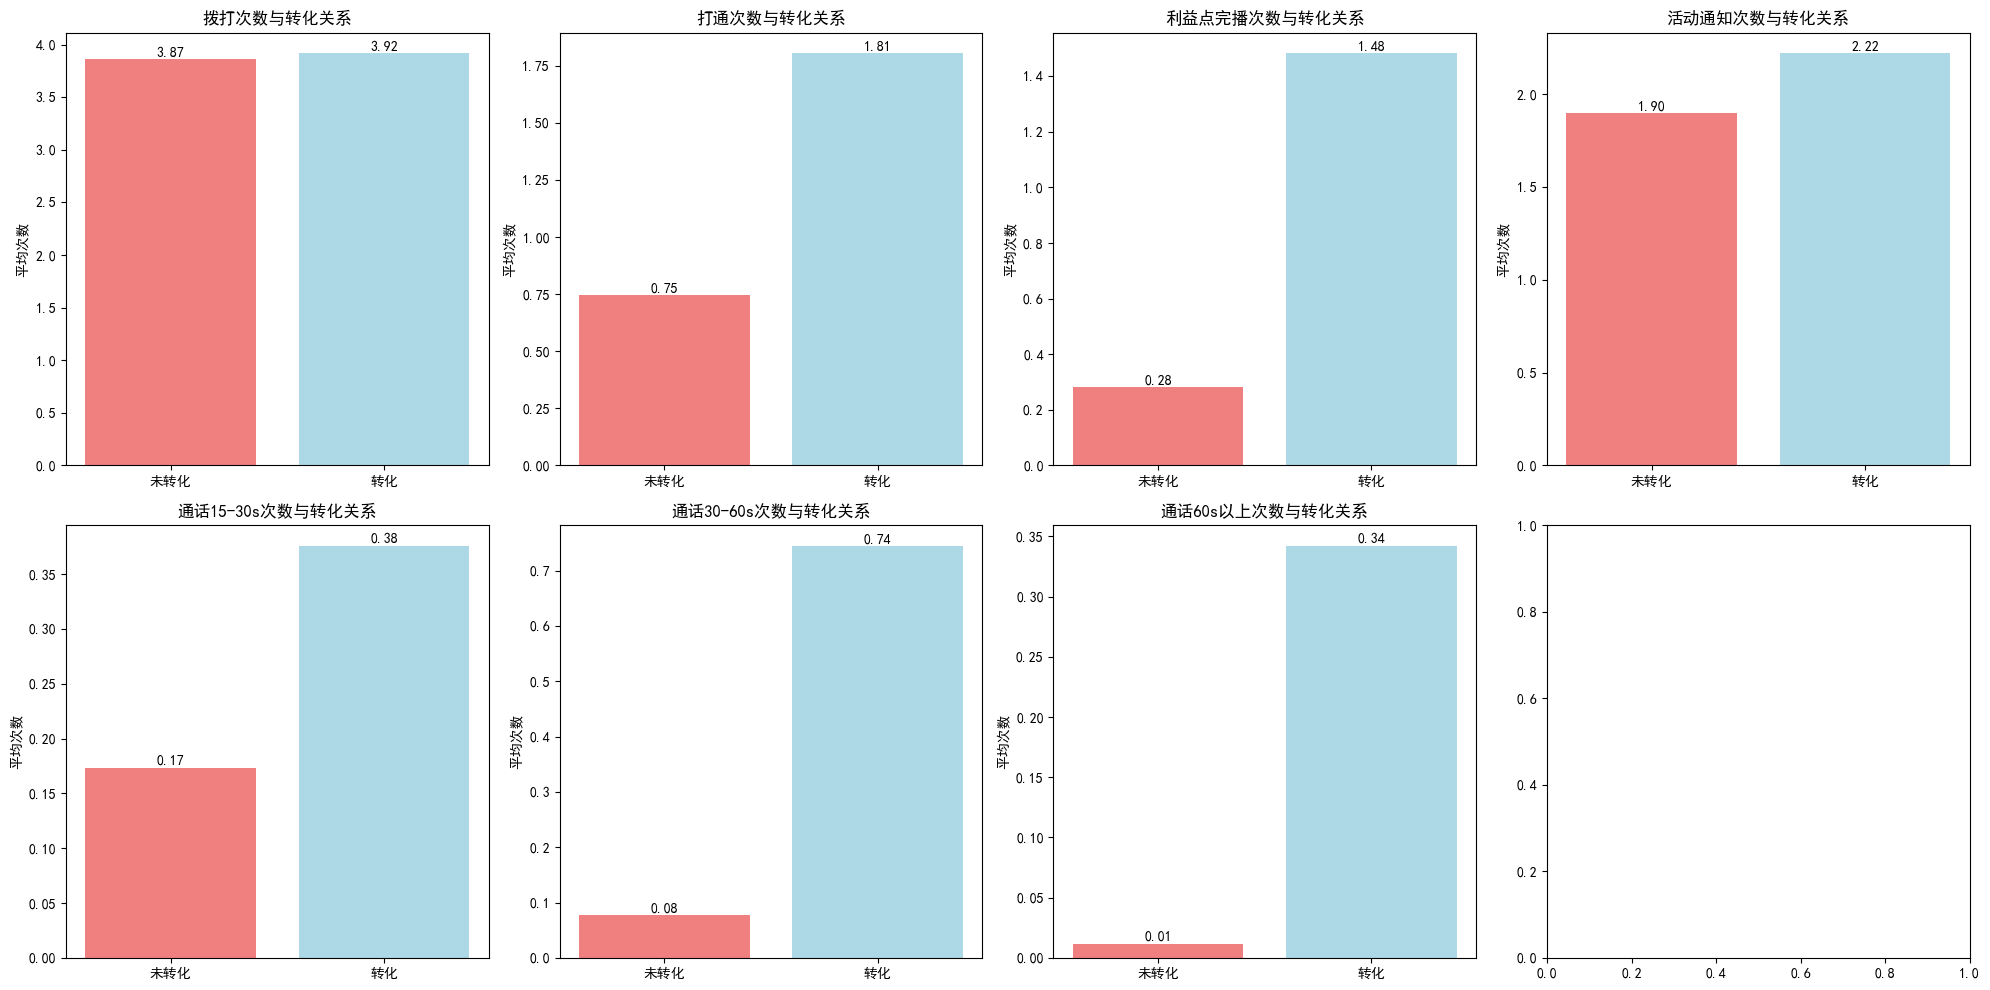

In [68]:
# 分析外呼接触相关变量与转化的关系
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False

# 创建一个包含外呼相关数值变量的子集
call_features = ['拨打次数', '打通次数', '利益点完播次数', '活动通知次数', 
                 '通话15-30s次数', '通话30-60s次数', '通话60s以上次数']

print("=== 外呼接触变量与转化的关系分析 ===")
for feature in call_features:
    converted = df[df['是否转化成交'] == 1][feature]
    not_converted = df[df['是否转化成交'] == 0][feature]
    
    print(f"\n{feature}:")
    print(f"  转化客户平均值: {converted.mean():.2f}")
    print(f"  未转化客户平均值: {not_converted.mean():.2f}")
    print(f"  差异: {converted.mean() - not_converted.mean():.2f}")

# 创建可视化图表
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(call_features):
    # 按转化情况分组计算平均值
    avg_by_conversion = df.groupby('是否转化成交')[feature].mean()
    
    axes[i].bar(['未转化', '转化'], avg_by_conversion.values, 
                color=['lightcoral', 'lightblue'])
    axes[i].set_title(f'{feature}与转化关系')
    axes[i].set_ylabel('平均次数')
    
    # 添加数值标签
    for j, v in enumerate(avg_by_conversion.values):
        axes[i].text(j, v + 0.001, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


=== 统计显著性检验 ===

资源渠道:
  卡方值: 97.5969
  p值: 0.000000
  显著性: 显著

是否接触过卓越:
  卡方值: 28.9601
  p值: 0.000000
  显著性: 显著

是否领过资料:
  卡方值: 28.9601
  p值: 0.000000
  显著性: 显著

long_呼叫时段:
  卡方值: 13.4083
  p值: 0.098551
  显著性: 不显著

long_是否工作日:
  卡方值: 2.8735
  p值: 0.090047
  显著性: 不显著

long_周几:
  卡方值: 17.7030
  p值: 0.007019
  显著性: 显著

long_客户意向_AI:
  卡方值: 2650.4291
  p值: 0.000000
  显著性: 显著

long_客户意向_人工:
  卡方值: 2692.6814
  p值: 0.000000
  显著性: 显著

=== 数值变量相关性分析 ===
拨打次数: 0.0003
打通次数: 0.0180
利益点完播次数: 0.0328
活动通知次数: 0.0046
通话15-30s次数: 0.0072
通话30-60s次数: 0.0365
通话60s以上次数: 0.0482

=== 按相关性强度排序 ===
通话60s以上次数: 0.0482
通话30-60s次数: 0.0365
利益点完播次数: 0.0328
打通次数: 0.0180
通话15-30s次数: 0.0072
活动通知次数: 0.0046
拨打次数: 0.0003

总体转化率: 0.0003 (0.03%)


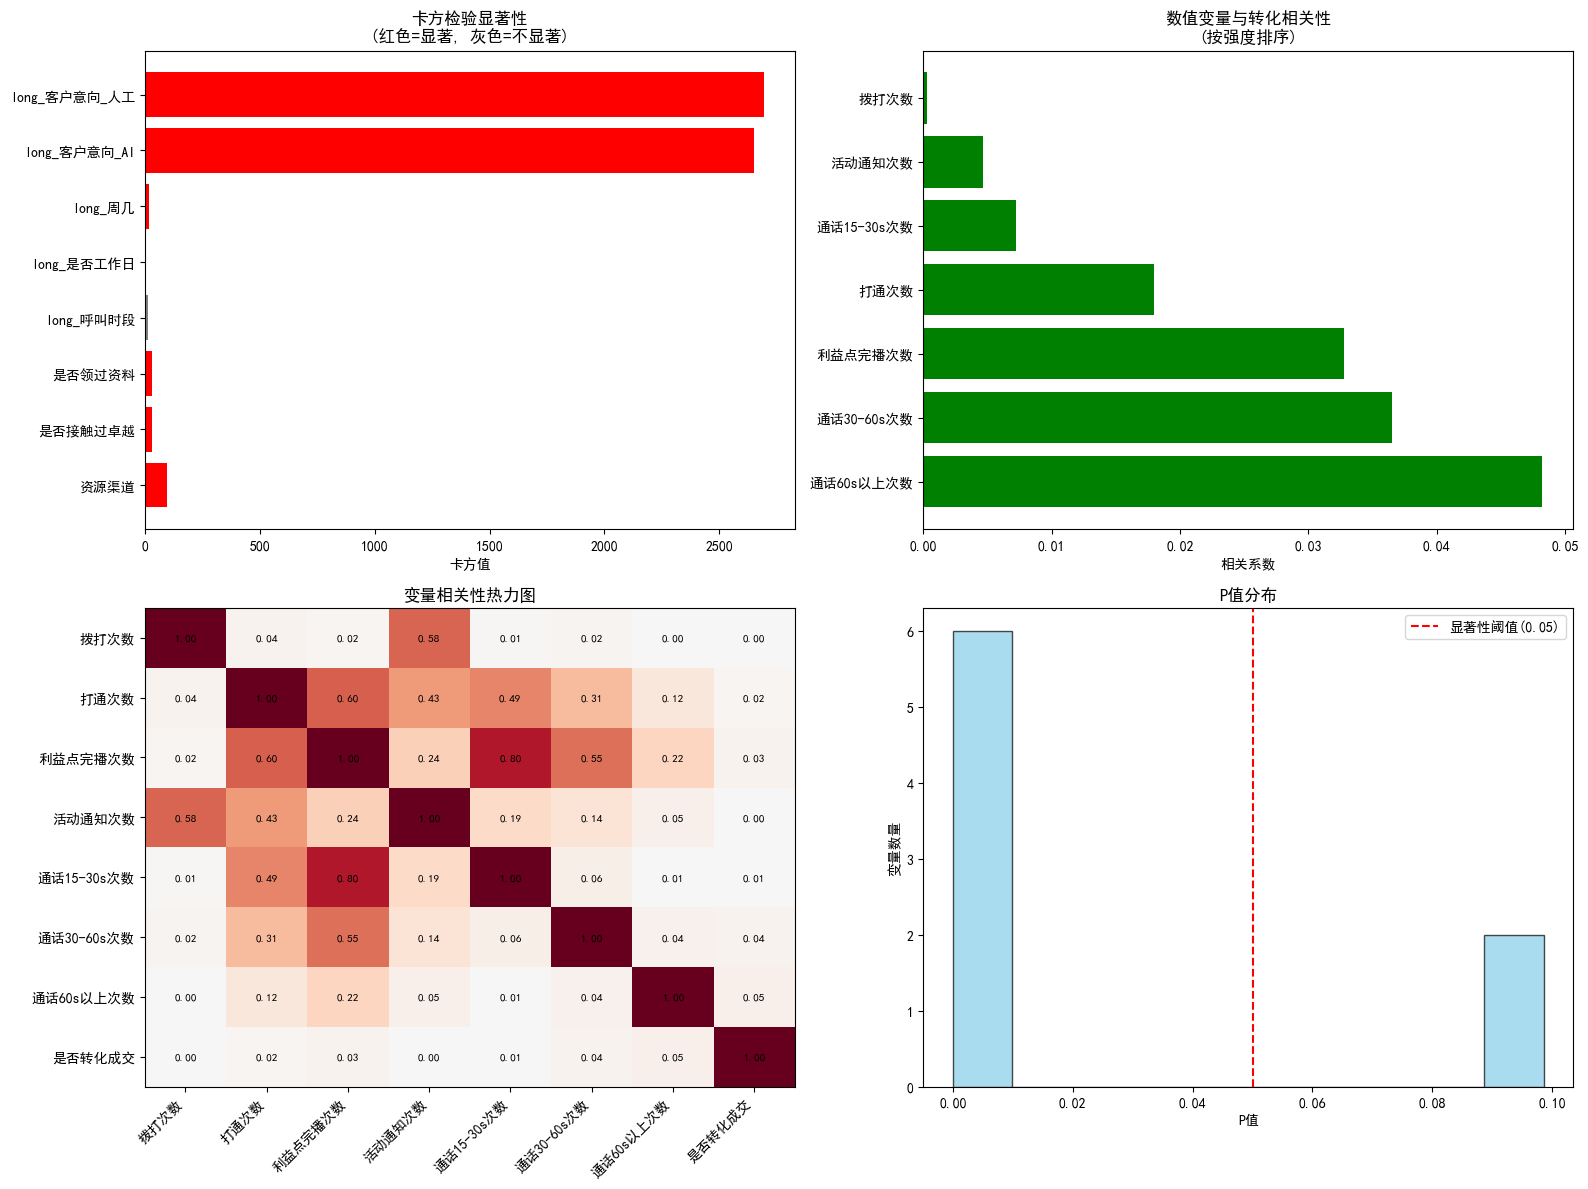

In [69]:
# 相关性分析和总结
from scipy.stats import chi2_contingency
import numpy as np

print("=== 统计显著性检验 ===")

# 定义分类变量
categorical_vars = ['资源渠道', '是否接触过卓越', '是否领过资料', 'long_呼叫时段', 
                   'long_是否工作日', 'long_周几', 'long_客户意向_AI', 'long_客户意向_人工']

# 进行卡方检验
chi2_results = {}
for var in categorical_vars:
    # 创建交叉表
    crosstab = pd.crosstab(df[var], df['是否转化成交'])
    # 进行卡方检验
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    chi2_results[var] = {'chi2': chi2, 'p_value': p_value}
    
    print(f"\n{var}:")
    print(f"  卡方值: {chi2:.4f}")
    print(f"  p值: {p_value:.6f}")
    print(f"  显著性: {'显著' if p_value < 0.05 else '不显著'}")

print("\n=== 数值变量相关性分析 ===")
# 计算数值变量与转化的相关性
numeric_vars = ['拨打次数', '打通次数', '利益点完播次数', '活动通知次数', 
               '通话15-30s次数', '通话30-60s次数', '通话60s以上次数']

correlations = {}
for var in numeric_vars:
    correlation = df[var].corr(df['是否转化成交'])
    correlations[var] = correlation
    print(f"{var}: {correlation:.4f}")

# 创建相关性排序
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\n=== 按相关性强度排序 ===")
for var, corr in sorted_correlations:
    print(f"{var}: {corr:.4f}")

# 计算转化率
conversion_rate = df['是否转化成交'].mean()
print(f"\n总体转化率: {conversion_rate:.4f} ({conversion_rate*100:.2f}%)")

# 添加可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 卡方检验显著性可视化
chi2_vars = list(chi2_results.keys())
chi2_values = [chi2_results[var]['chi2'] for var in chi2_vars]
p_values = [chi2_results[var]['p_value'] for var in chi2_vars]
colors = ['red' if p < 0.05 else 'gray' for p in p_values]

axes[0,0].barh(range(len(chi2_vars)), chi2_values, color=colors)
axes[0,0].set_yticks(range(len(chi2_vars)))
axes[0,0].set_yticklabels(chi2_vars)
axes[0,0].set_title('卡方检验显著性\n(红色=显著, 灰色=不显著)')
axes[0,0].set_xlabel('卡方值')

# 2. 数值变量相关性可视化
corr_vars = [var for var, corr in sorted_correlations]
corr_values = [corr for var, corr in sorted_correlations]
colors = ['green' if corr > 0 else 'red' for corr in corr_values]

axes[0,1].barh(range(len(corr_vars)), corr_values, color=colors)
axes[0,1].set_yticks(range(len(corr_vars)))
axes[0,1].set_yticklabels(corr_vars)
axes[0,1].set_title('数值变量与转化相关性\n(按强度排序)')
axes[0,1].set_xlabel('相关系数')
axes[0,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 3. 相关性热力图
correlation_matrix = df[numeric_vars + ['是否转化成交']].corr()
im = axes[1,0].imshow(correlation_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_xticks(range(len(correlation_matrix.columns)))
axes[1,0].set_yticks(range(len(correlation_matrix.columns)))
axes[1,0].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
axes[1,0].set_yticklabels(correlation_matrix.columns)
axes[1,0].set_title('变量相关性热力图')

# 添加数值标注
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        axes[1,0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                      ha='center', va='center', fontsize=8)

# 4. P值分布
axes[1,1].hist(p_values, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].axvline(x=0.05, color='red', linestyle='--', label='显著性阈值(0.05)')
axes[1,1].set_title('P值分布')
axes[1,1].set_xlabel('P值')
axes[1,1].set_ylabel('变量数量')
axes[1,1].legend()

plt.tight_layout()
plt.show()


=== 已转化客户的成交信息分析 ===

--- TMS系统成交信息 ---
TMS系统有成交记录的客户数: 139

首次成交金额统计:
count      139.00
mean      4908.31
std       3698.12
min          0.00
25%       2700.00
50%       4578.00
75%       6113.50
max      22489.00
Name: 首次成交金额_TMS, dtype: float64

首次购买科目分布:
首次购买科目_TMS
[多元思维]                               37
[悦读与表达, 多元思维, 思辨读写]                  22
[思辨读写]                               17
[奇点, 悦读与表达, 多元思维, 溯源]                 9
[编程]                                  9
[悦读与表达, 多元思维]                         7
[悦读与表达]                               7
[多元思维, 思辨读写]                          7
[奇点]                                  3
[奇点, 多元思维, 溯源]                        3
[心怀天下, 悦读与表达, 溯源, 思辨读写]               1
[奇点, 悦读与表达, 多元思维, 以古为鉴, 溯源, 思辨读写]     1
[悦读与表达, 多元思维, 溯源]                     1
[悦读与表达, 思辨读写]                         1
[心怀天下, 以古为鉴]                          1
[心怀天下, 奇点, 以古为鉴, 溯源]                  1
[奇点, 多元思维, 思辨读写]                      1
[非学科]                                 1
[谈古说今]    

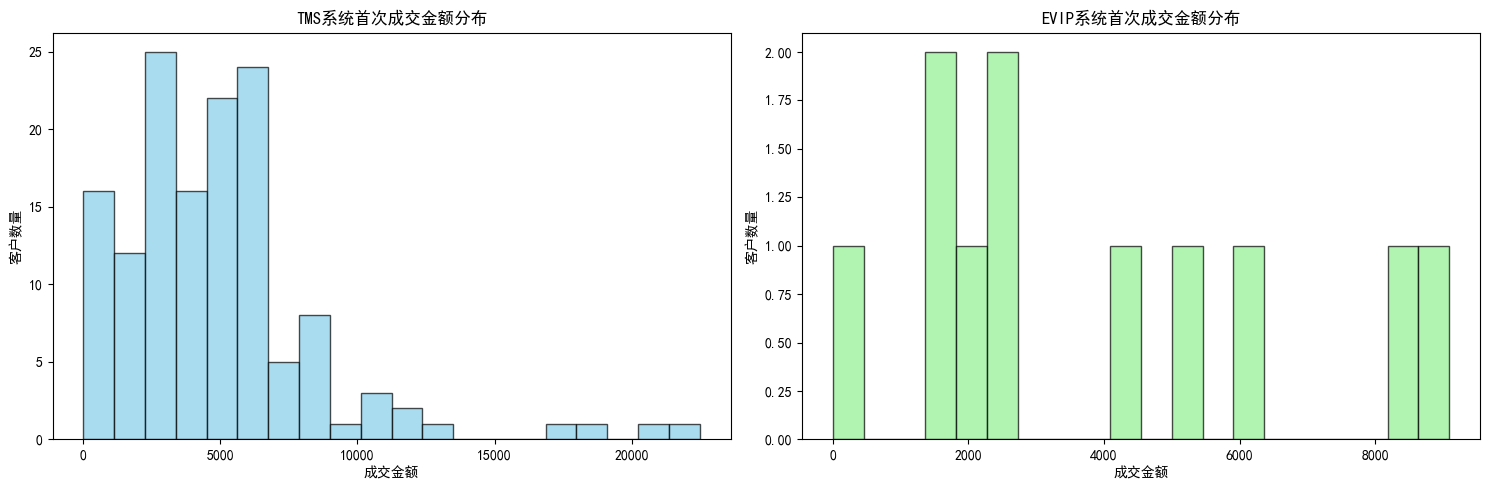

In [72]:
# 分析已转化客户的成交信息
print("=== 已转化客户的成交信息分析 ===")
converted_customers = df[df['是否转化成交'] == 1].copy()
# 首次成交信息分析
print("\n--- TMS系统成交信息 ")
tms_converted = converted_customers.dropna(subset=['首次成交金额_TMS'])
print(f"TMS系统有成交记录的客户数: {len(tms_converted)}")

if len(tms_converted) > 0:
    print("\n首次成交金额统计:")
    print(tms_converted['首次成交金额_TMS'].describe().round(2))
    
    print("\n首次购买科目分布:")
    print(tms_converted['首次购买科目_TMS'].value_counts())
    
    print("\n首次购买科数分布:")
    print(tms_converted['首次购买科数_TMS'].value_counts())

print("\n--- EVIP系统成交信息 ")
evip_converted = converted_customers.dropna(subset=['首次成交金额_EVIP'])
print(f"EVIP系统有成交记录的客户数: {len(evip_converted)}")

if len(evip_converted) > 0:
    print("\n首次成交金额统计:")
    print(evip_converted['首次成交金额_EVIP'].describe().round(2))
    
    print("\n首次购买科目分布:")
    evip_subjects = evip_converted['首次购买科目_EVIP'].dropna()
    if len(evip_subjects) > 0:
        print(evip_subjects.value_counts())
    
    print("\n首次购买科数分布:")
    print(evip_converted['首次购买科数_EVIP'].value_counts())

# 可视化成交金额分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if len(tms_converted) > 0:
    axes[0].hist(tms_converted['首次成交金额_TMS'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('TMS系统首次成交金额分布')
    axes[0].set_xlabel('成交金额')
    axes[0].set_ylabel('客户数量')

if len(evip_converted) > 0:
    axes[1].hist(evip_converted['首次成交金额_EVIP'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].set_title('EVIP系统首次成交金额分布')
    axes[1].set_xlabel('成交金额')
    axes[1].set_ylabel('客户数量')

plt.tight_layout()
plt.show()


In [ ]:
# 深入挖掘最长通话 vs 最近通话的差异分析
print("=== 最长通话 vs 最近通话深度对比分析 ===")

# 筛选有最长通话记录的已转化客户
有长通话记录的转化客户 = converted_customers.dropna(subset=['long_通话日期']).copy()
print(f"有最长通话记录的转化客户数: {len(有长通话记录的转化客户)} / {len(converted_customers)}")

if len(有长通话记录的转化客户) > 0:
    
    # 1. 时间间隔分析
    print("\n--- 最长通话与最近通话的时间间隔分析 ")
    
    有长通话记录的转化客户['通话时间间隔'] = (有长通话记录的转化客户['latest_通话日期'] - 
                                       有长通话记录的转化客户['long_通话日期']).dt.days
    
    时间间隔统计 = 有长通话记录的转化客户['通话时间间隔'].describe()
    print("时间间隔统计（天）:")
    print(时间间隔统计.round(2))
    
    # 分析不同时间间隔的转化效果
    有长通话记录的转化客户['时间间隔分组'] = pd.cut(有长通话记录的转化客户['通话时间间隔'], 
                                        bins=[-1, 0, 7, 30, 90, float('inf')],
                                        labels=['同一天', '1周内', '1月内', '3月内', '3月以上'])
    
    print("\n时间间隔分组分布:")
    print(有长通话记录的转化客户['时间间隔分组'].value_counts())
    
    # 2. 客户意向变化分析
    print("\n--- 客户意向变化轨迹分析 ")
    
    意向变化 = pd.crosstab(有长通话记录的转化客户['long_客户意向_人工'], 
                      有长通话记录的转化客户['latest_客户意向_人工'],
                      margins=True)
    print("客户意向变化矩阵（从最长通话到最近通话）:")
    print(意向变化)
    
    # 识别意向提升的客户
    意向等级映射 = {'A(强意向)': 4, 'B(一般意向)': 3, 'C(弱意向)': 2, 'D(无意向)': 1, 'E(未接通)': 0}
    
    有长通话记录的转化客户['long_意向分数'] = 有长通话记录的转化客户['long_客户意向_人工'].map(意向等级映射)
    有长通话记录的转化客户['latest_意向分数'] = 有长通话记录的转化客户['latest_客户意向_人工'].map(意向等级映射)
    有长通话记录的转化客户['意向变化'] = (有长通话记录的转化客户['latest_意向分数'] - 
                                   有长通话记录的转化客户['long_意向分数'])
    
    print(f"\n意向变化统计:")
    print(f"意向提升客户: {(有长通话记录的转化客户['意向变化'] > 0).sum()}")
    print(f"意向保持客户: {(有长通话记录的转化客户['意向变化'] == 0).sum()}")
    print(f"意向下降客户: {(有长通话记录的转化客户['意向变化'] < 0).sum()}")
    
else:
    print("没有足够的最长通话记录进行对比分析")


=== 最长通话 vs 最近通话深度对比分析 ===
有最长通话记录的转化客户数: 143 / 149

--- 最长通话与最近通话的时间间隔分析 ---
时间间隔统计（天）:
count    143.00
mean      26.73
std       45.05
min        0.00
25%        0.00
50%        0.00
75%       36.00
max      204.00
Name: 通话时间间隔, dtype: float64

时间间隔分组分布:
时间间隔分组
同一天     88
3月内     25
3月以上    17
1月内     13
1周内      0
Name: count, dtype: int64

--- 客户意向变化轨迹分析 ---
客户意向变化矩阵（从最长通话到最近通话）:
latest_客户意向_人工  A(意向较强)  B(意向一般)  C(待筛选)  D(无意向)  E(未接通)  H(报了你们课程)  J(语音助手)  \
long_客户意向_人工                                                                   
A(意向较强)              13        0       3       0       3          1        1   
B(意向一般)               2       45       6       4       8          1        2   
C(待筛选)                0        0      21       0       2          0        1   
D(无意向)                0        0       2       5       3          0        0   
G(客户忙等情况)             0        0       1       0       0          0        0   
H(报了你们课程)             2        0       1       0     

=== 通话行为模式和转化关键节点分析 ===

--- 通话时段策略变化分析 ---
通话时段变化矩阵:
latest_呼叫时段  11点之前  15点  16点  17点  19点  All
long_呼叫时段                                  
11点之前            3    0    0    0    0    3
14点              0    0    0    0    1    1
15点              0    8    0    0    8   16
16点              0    0    7    0    3   10
17点              0    0    1    3    8   12
18点              0    0    0    0    1    1
19点              0    3    4    0   93  100
All              3   11   12    3  114  143

最有效的时段转换模式:
  19点 → 19点: 93人
  15点 → 19点: 8人
  15点 → 15点: 8人
  17点 → 19点: 8人
  16点 → 16点: 7人
  19点 → 16点: 4人
  11点之前 → 11点之前: 3人
  19点 → 15点: 3人
  16点 → 19点: 3人
  17点 → 17点: 3人

--- 工作日策略变化分析 ---
工作日策略变化矩阵:
latest_是否工作日   否    是  All
long_是否工作日                
否             20    8   28
是             12  103  115
All           32  111  143

--- 通话活动类型演变分析 ---
活动类型变化矩阵:
latest_活动类型  其他  考试类  资料类  邀约类  All
long_活动类型                          
其他           26    3    0    1   30
考试类           0   18    0

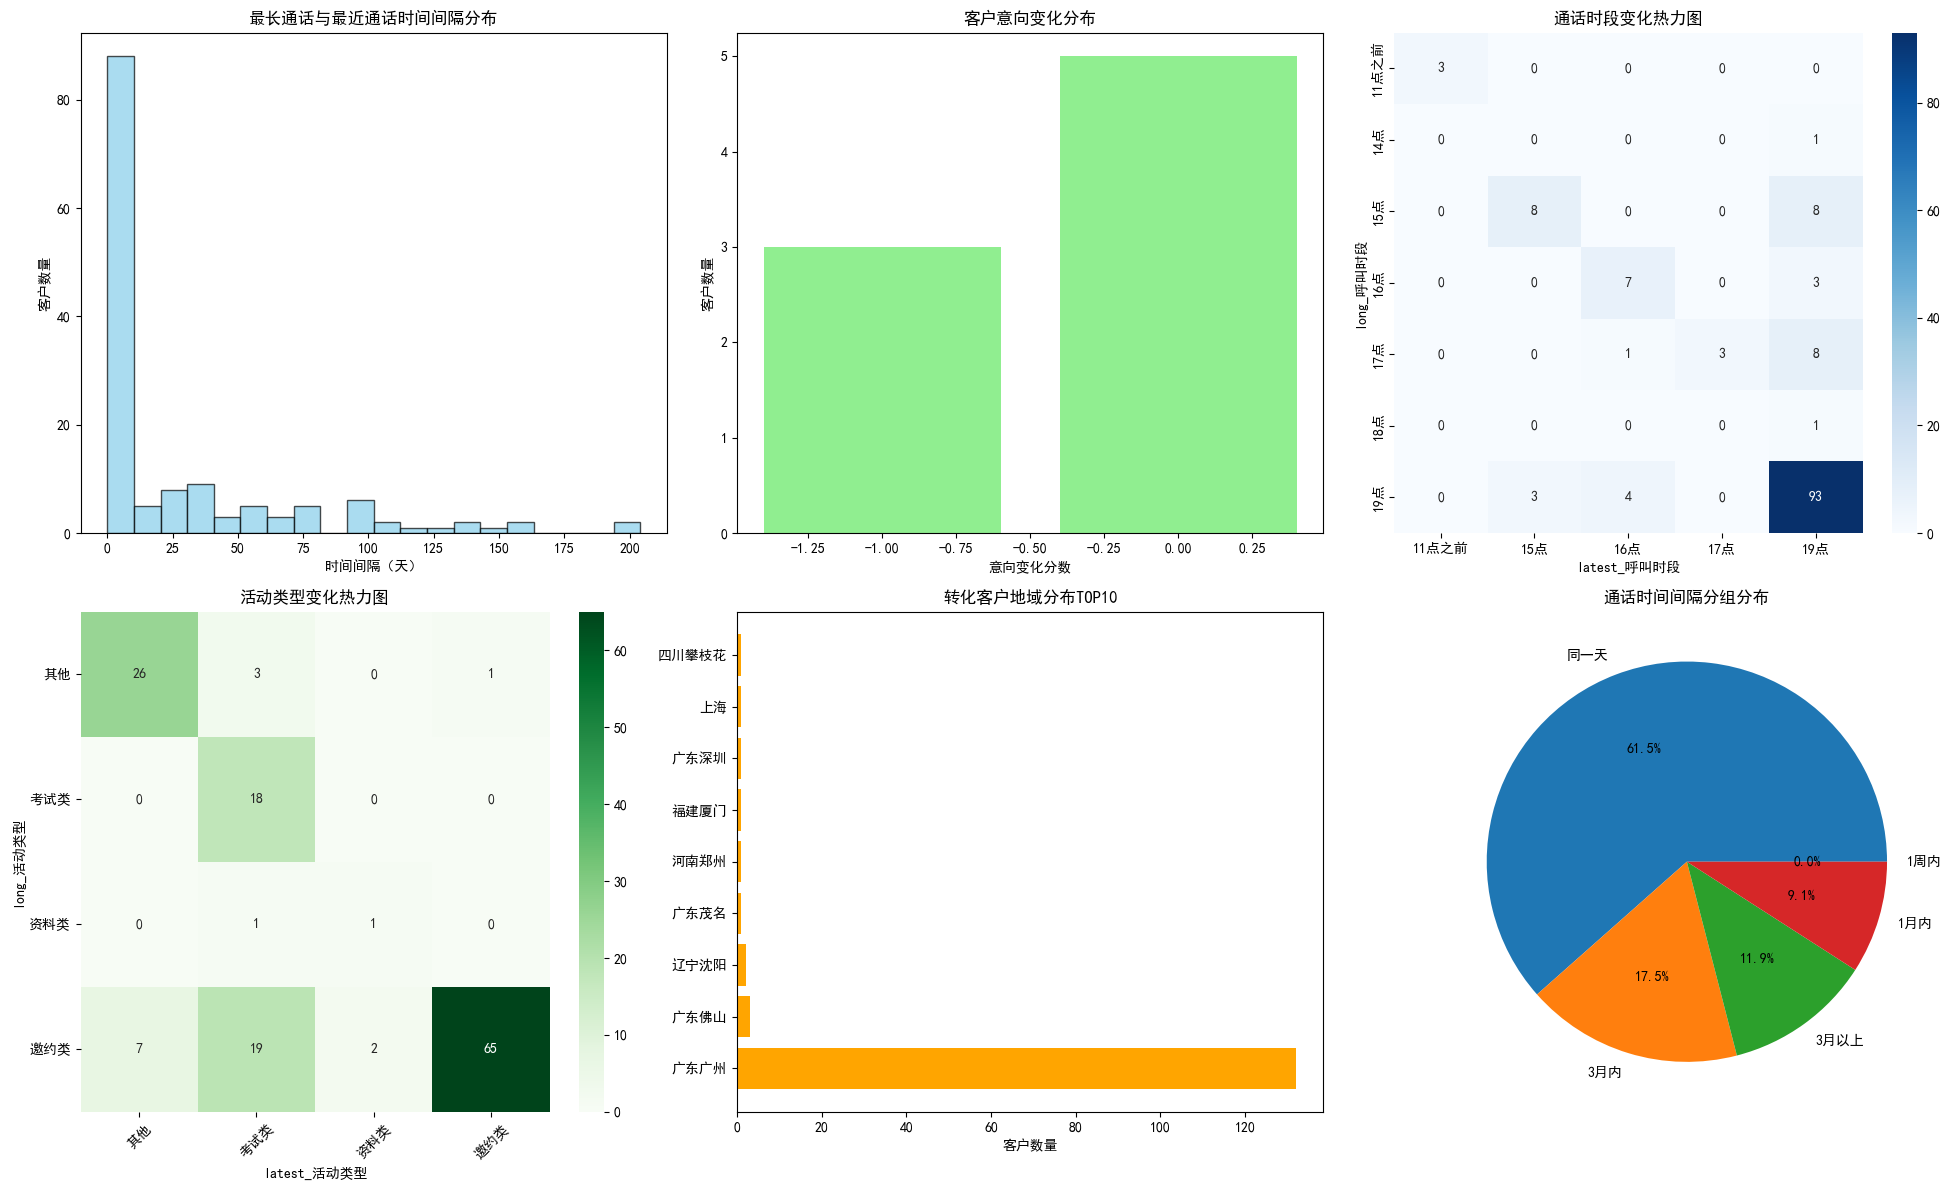

In [ ]:
# 深入分析通话行为模式和转化关键节点
print("=== 通话行为模式和转化关键节点分析 ===")

if len(有长通话记录的转化客户) > 0:
    
    # 3. 通话时段策略变化分析
    print("\n--- 通话时段策略变化分析 ")
    
    时段变化 = pd.crosstab(有长通话记录的转化客户['long_呼叫时段'], 
                      有长通话记录的转化客户['latest_呼叫时段'],
                      margins=True)
    print("通话时段变化矩阵:")
    print(时段变化)
    
    # 识别最有效的时段组合
    print("\n最有效的时段转换模式:")
    时段组合 = 有长通话记录的转化客户.groupby(['long_呼叫时段', 'latest_呼叫时段']).size().reset_index(name='客户数')
    时段组合 = 时段组合.sort_values('客户数', ascending=False).head(10)
    for _, row in 时段组合.iterrows():
        print(f"  {row['long_呼叫时段']} → {row['latest_呼叫时段']}: {row['客户数']}人")
    
    # 4. 工作日策略变化分析
    print("\n--- 工作日策略变化分析 ")
    
    工作日变化 = pd.crosstab(有长通话记录的转化客户['long_是否工作日'], 
                       有长通话记录的转化客户['latest_是否工作日'],
                       margins=True)
    print("工作日策略变化矩阵:")
    print(工作日变化)
    
    # 5. 活动类型变化分析
    print("\n--- 通话活动类型演变分析 ")
    
    # 提取活动关键词进行分析
    def 提取活动关键词(活动名称):
        if pd.isna(活动名称):
            return "未知"
        活动名称 = str(活动名称)
        if "邀约" in 活动名称:
            return "邀约类"
        elif "试听" in 活动名称:
            return "试听类"
        elif "资料" in 活动名称 or "手册" in 活动名称:
            return "资料类"
        elif "考试" in 活动名称 or "真题" in 活动名称:
            return "考试类"
        elif "激活" in 活动名称:
            return "激活类"
        else:
            return "其他"
    
    有长通话记录的转化客户['long_活动类型'] = 有长通话记录的转化客户['long_通话活动名称'].apply(提取活动关键词)
    有长通话记录的转化客户['latest_活动类型'] = 有长通话记录的转化客户['latest_通话活动名称'].apply(提取活动关键词)
    
    活动类型变化 = pd.crosstab(有长通话记录的转化客户['long_活动类型'], 
                        有长通话记录的转化客户['latest_活动类型'],
                        margins=True)
    print("活动类型变化矩阵:")
    print(活动类型变化)
    
    # 6. 地域因素分析
    print("\n--- 地域因素对转化的影响 ")
    
    地域分布 = 有长通话记录的转化客户['long_号码归属地'].value_counts().head(10)
    print("转化客户主要归属地分布:")
    print(地域分布)

# 创建综合可视化
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

if len(有长通话记录的转化客户) > 0:
    
    # 时间间隔分布
    axes[0,0].hist(有长通话记录的转化客户['通话时间间隔'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('最长通话与最近通话时间间隔分布')
    axes[0,0].set_xlabel('时间间隔（天）')
    axes[0,0].set_ylabel('客户数量')
    
    # 意向变化分布
    意向变化分布 = 有长通话记录的转化客户['意向变化'].value_counts().sort_index()
    axes[0,1].bar(意向变化分布.index, 意向变化分布.values, color='lightgreen')
    axes[0,1].set_title('客户意向变化分布')
    axes[0,1].set_xlabel('意向变化分数')
    axes[0,1].set_ylabel('客户数量')
    
    # 时段变化热力图
    时段变化矩阵 = pd.crosstab(有长通话记录的转化客户['long_呼叫时段'], 
                          有长通话记录的转化客户['latest_呼叫时段'])
    sns.heatmap(时段变化矩阵, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
    axes[0,2].set_title('通话时段变化热力图')
    
    # 活动类型变化
    活动变化矩阵 = pd.crosstab(有长通话记录的转化客户['long_活动类型'], 
                          有长通话记录的转化客户['latest_活动类型'])
    sns.heatmap(活动变化矩阵, annot=True, fmt='d', cmap='Greens', ax=axes[1,0])
    axes[1,0].set_title('活动类型变化热力图')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].tick_params(axis='y', rotation=0)
    
    # 地域分布
    地域前10 = 有长通话记录的转化客户['long_号码归属地'].value_counts().head(10)
    axes[1,1].barh(range(len(地域前10)), 地域前10.values, color='orange')
    axes[1,1].set_yticks(range(len(地域前10)))
    axes[1,1].set_yticklabels(地域前10.index)
    axes[1,1].set_title('转化客户地域分布TOP10')
    axes[1,1].set_xlabel('客户数量')
    
    # 时间间隔分组对比
    时间间隔分组统计 = 有长通话记录的转化客户['时间间隔分组'].value_counts()
    axes[1,2].pie(时间间隔分组统计.values, labels=时间间隔分组统计.index, autopct='%1.1f%%')
    axes[1,2].set_title('通话时间间隔分组分布')

plt.tight_layout()
plt.show()


In [77]:
# 转化周期计算：从最长通话到首次成交的真实转化周期
print("真实转化周期分析")

# 重新筛选有最长通话记录和成交记录的客户
有完整记录的转化客户 = converted_customers.dropna(subset=['long_通话日期']).copy()

# 合并TMS和EVIP的首次成交日期
有完整记录的转化客户['首次成交日期'] = 有完整记录的转化客户['首次成交日期_TMS'].combine_first(
    有完整记录的转化客户['首次成交日期_EVIP'])

# 筛选有成交日期的客户
有成交日期的客户 = 有完整记录的转化客户.dropna(subset=['首次成交日期']).copy()

print(f"有最长通话记录的转化客户: {len(有完整记录的转化客户)}")
print(f"有完整成交日期的客户: {len(有成交日期的客户)}")

if len(有成交日期的客户) > 0:
    
    # 计算真实转化周期：从最长通话到首次成交
    有成交日期的客户['真实转化周期'] = (有成交日期的客户['首次成交日期'] - 
                                有成交日期的客户['long_通话日期']).dt.days
    
    print(f"真实转化周期统计分析 ")
    转化周期统计 = 有成交日期的客户['真实转化周期'].describe()
    print("从最长通话到首次成交的转化周期统计（天）:")
    print(转化周期统计.round(2))
    
    # 过滤异常值（负数或过大的值）
    正常转化周期客户 = 有成交日期的客户[
        (有成交日期的客户['真实转化周期'] >= 0) & 
        (有成交日期的客户['真实转化周期'] <= 365)
    ].copy()
    
    print(f"\n过滤异常值后的有效样本: {len(正常转化周期客户)} / {len(有成交日期的客户)}")
    
    if len(正常转化周期客户) > 0:
        print("真实转化周期分析")
        
        # 重新计算转化周期统计
        正常周期统计 = 正常转化周期客户['真实转化周期'].describe()
        print("正常转化周期统计:")
        print(正常周期统计.round(2))
        
        # 转化周期分组
        正常转化周期客户['转化速度分组'] = pd.cut(正常转化周期客户['真实转化周期'], 
                                      bins=[-1, 0, 1, 7, 30, 90, float('inf')],
                                      labels=['当天转化', '次日转化', '一周内', '一月内', '三月内', '长期转化'])
        
        print("\n转化速度分组分布:")
        转化速度分布 = 正常转化周期客户['转化速度分组'].value_counts()
        print(转化速度分布)
        print("\n各组占比:")
        print((转化速度分布 / len(正常转化周期客户) * 100).round(1))

真实转化周期分析
有最长通话记录的转化客户: 143
有完整成交日期的客户: 143
真实转化周期统计分析 
从最长通话到首次成交的转化周期统计（天）:
count    143.00
mean      33.76
std       42.97
min      -74.00
25%       13.00
50%       23.00
75%       40.00
max      228.00
Name: 真实转化周期, dtype: float64

过滤异常值后的有效样本: 132 / 143
真实转化周期分析
正常转化周期统计:
count    132.00
mean      39.04
std       40.01
min        0.00
25%       17.00
50%       24.00
75%       48.00
max      228.00
Name: 真实转化周期, dtype: float64

转化速度分组分布:
转化速度分组
一月内     60
三月内     44
一周内     14
长期转化    12
次日转化     1
当天转化     1
Name: count, dtype: int64

各组占比:
转化速度分组
一月内     45.5
三月内     33.3
一周内     10.6
长期转化     9.1
次日转化     0.8
当天转化     0.8
Name: count, dtype: float64


基于真实转化周期的价值分析
转化周期与成交金额关系分析 
各转化速度组的成交金额统计:
        count     mean  median      std
转化速度分组                                 
当天转化        1  2700.00  2700.0      NaN
次日转化        1  3358.00  3358.0      NaN
一周内        13  3978.92  3228.0  3193.83
一月内        59  4859.37  5000.0  2588.40
三月内        41  6004.37  5147.0  5269.14
长期转化       12  4938.08  4800.0  2816.97
转化效率黄金指标 
各组转化效率对比:
      客户数量  平均转化周期  平均拨打次数  平均打通次数    打通率    完播率  有金额客户       平均成交金额
当天转化   1.0     0.0     2.0     2.0  1.000  1.000    1.0  2700.000000
次日转化   1.0     1.0     1.0     1.0  1.000  1.000    1.0  3358.000000
一周内   14.0     4.2     4.4     2.4  0.645  0.882   13.0  3978.923077
一月内   60.0    19.2     2.6     1.6  0.799  0.900   59.0  4859.372881
三月内   44.0    50.9     4.4     1.9  0.656  0.794   41.0  6004.365854
长期转化  12.0   141.8     8.6     2.5  0.439  0.872   12.0  4938.083333
最优转化模式识别
最优转化模式: 一周内 (效率得分: 21)
一周内转化模式的成功要素:
  - 客户数量: 14
  - 平均转化周期: 4.2天
  - 主要意向等级: B(意向一般)
  - 最佳资源渠道: 成长沉睡激活
  - 最佳通话时段: 19点
最优

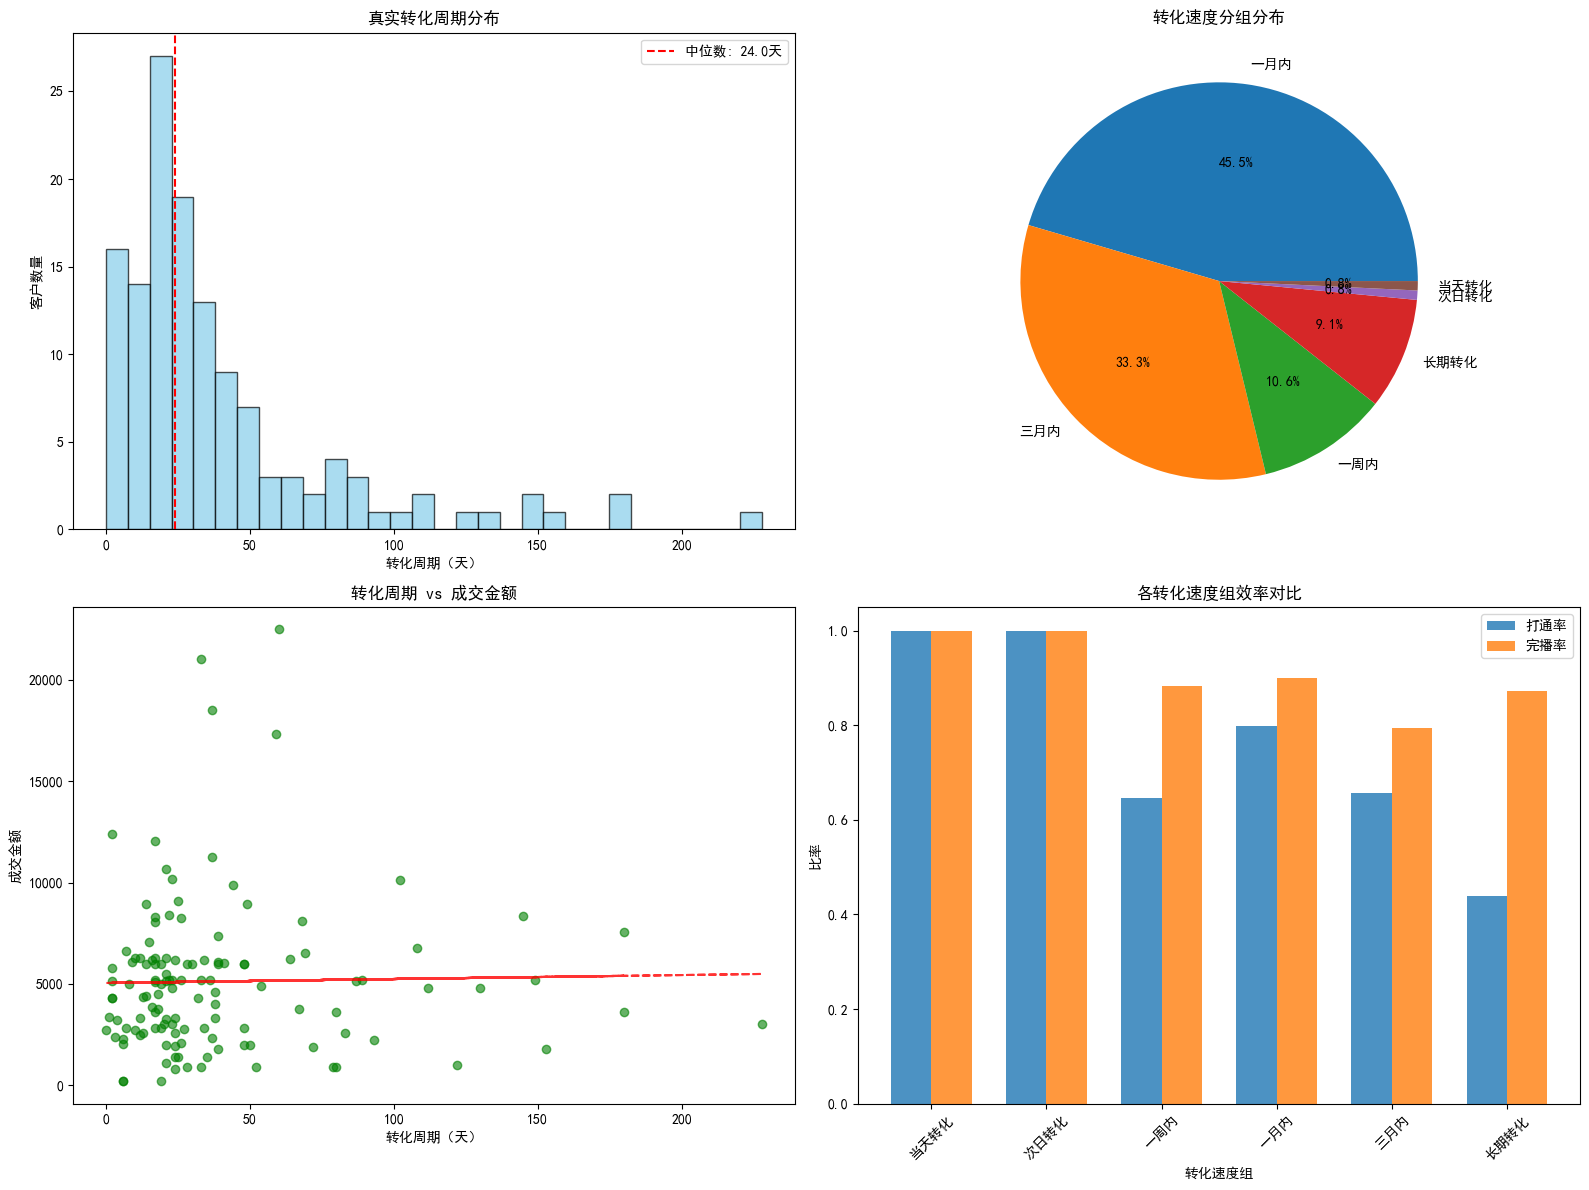

In [79]:
# 基于真实转化周期的成交金额和价值分析
print("基于真实转化周期的价值分析")

if len(正常转化周期客户) > 0:
    
    # 合并成交金额
    正常转化周期客户['总成交金额_修正'] = (正常转化周期客户['首次成交金额_TMS'].fillna(0) + 
                                  正常转化周期客户['首次成交金额_EVIP'].fillna(0))
    
    # 分析转化周期与成交金额的关系
    print("转化周期与成交金额关系分析 ")
    
    # 按转化速度分组分析成交金额
    金额有效客户 = 正常转化周期客户[正常转化周期客户['总成交金额_修正'] > 0].copy()
    
    if len(金额有效客户) > 0:
        速度金额分析 = 金额有效客户.groupby('转化速度分组')['总成交金额_修正'].agg(['count', 'mean', 'median', 'std']).round(2)
        print("各转化速度组的成交金额统计:")
        print(速度金额分析)
        
        # 计算转化效率指标
        print("转化效率黄金指标 ")
        
        效率指标 = {}
        for 组名 in 正常转化周期客户['转化速度分组'].cat.categories:
            组数据 = 正常转化周期客户[正常转化周期客户['转化速度分组'] == 组名]
            if len(组数据) > 0:
                效率指标[组名] = {
                    '客户数量': len(组数据),
                    '平均转化周期': 组数据['真实转化周期'].mean().round(1),
                    '平均拨打次数': 组数据['拨打次数'].mean().round(1),
                    '平均打通次数': 组数据['打通次数'].mean().round(1),
                    '打通率': (组数据['打通次数'] / 组数据['拨打次数'].replace(0, 1)).mean().round(3),
                    '完播率': (组数据['利益点完播次数'] / 组数据['打通次数'].replace(0, 1)).mean().round(3),
                    '有金额客户': len(组数据[组数据['总成交金额_修正'] > 0]),
                    '平均成交金额': 组数据[组数据['总成交金额_修正'] > 0]['总成交金额_修正'].mean()
                }
        
        效率指标_df = pd.DataFrame(效率指标).T
        print("各组转化效率对比:")
        print(效率指标_df)
        
        # 识别最优转化模式
        print("最优转化模式识别")
        
        # 定义综合效率得分
        def 计算效率得分(组名, 指标):
            得分 = 0
            
            # 速度得分（转化越快得分越高）
            if 指标['平均转化周期'] <= 1:
                得分 += 10
            elif 指标['平均转化周期'] <= 7:
                得分 += 8
            elif 指标['平均转化周期'] <= 30:
                得分 += 6
            
            # 效率得分
            if 指标['打通率'] > 0.3:
                得分 += 5
            elif 指标['打通率'] > 0.2:
                得分 += 3
            
            if 指标['完播率'] > 0.5:
                得分 += 5
            elif 指标['完播率'] > 0.3:
                得分 += 3
            
            # 成交金额得分
            if pd.notna(指标['平均成交金额']) and 指标['平均成交金额'] > 0:
                if 指标['平均成交金额'] > 5000:
                    得分 += 5
                elif 指标['平均成交金额'] > 2000:
                    得分 += 3
                elif 指标['平均成交金额'] > 1000:
                    得分 += 1
            
            return 得分
        
        效率得分 = {}
        for 组名, 指标 in 效率指标.items():
            if 指标['客户数量'] >= 5:  # 只计算样本量足够的组
                效率得分[组名] = 计算效率得分(组名, 指标)
        
        if 效率得分:
            最优组 = max(效率得分, key=效率得分.get)
            print(f"最优转化模式: {最优组} (效率得分: {效率得分[最优组]})")
            
            最优组数据 = 正常转化周期客户[正常转化周期客户['转化速度分组'] == 最优组]
            print(f"{最优组}转化模式的成功要素:")
            print(f"  - 客户数量: {len(最优组数据)}")
            print(f"  - 平均转化周期: {最优组数据['真实转化周期'].mean():.1f}天")
            print(f"  - 主要意向等级: {最优组数据['long_客户意向_人工'].mode().values[0] if len(最优组数据['long_客户意向_人工'].mode()) > 0 else '未知'}")
            print(f"  - 最佳资源渠道: {最优组数据['资源渠道'].mode().values[0] if len(最优组数据['资源渠道'].mode()) > 0 else '未知'}")
            print(f"  - 最佳通话时段: {最优组数据['long_呼叫时段'].mode().values[0] if len(最优组数据['long_呼叫时段'].mode()) > 0 else '未知'}")
            
            # 最优组的行为模式
            最优组行为 = 最优组数据[['拨打次数', '打通次数', '利益点完播次数', '通话60s以上次数']].mean()
            print(f"最优组平均行为模式:")
            for 行为, 数值 in 最优组行为.items():
                print(f"    - {行为}: {数值:.1f}")

    # 创建转化周期可视化
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 转化周期分布直方图
    axes[0,0].hist(正常转化周期客户['真实转化周期'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('真实转化周期分布')
    axes[0,0].set_xlabel('转化周期（天）')
    axes[0,0].set_ylabel('客户数量')
    axes[0,0].axvline(正常转化周期客户['真实转化周期'].median(), color='red', linestyle='--', label=f'中位数: {正常转化周期客户["真实转化周期"].median():.1f}天')
    axes[0,0].legend()
    
    # 转化速度分组饼图
    转化速度分布 = 正常转化周期客户['转化速度分组'].value_counts()
    axes[0,1].pie(转化速度分布.values, labels=转化速度分布.index, autopct='%1.1f%%')
    axes[0,1].set_title('转化速度分组分布')
    
    # 转化周期与成交金额散点图
    if len(金额有效客户) > 0:
        axes[1,0].scatter(金额有效客户['真实转化周期'], 金额有效客户['总成交金额_修正'], alpha=0.6, color='green')
        axes[1,0].set_title('转化周期 vs 成交金额')
        axes[1,0].set_xlabel('转化周期（天）')
        axes[1,0].set_ylabel('成交金额')
        
        # 添加趋势线
        if len(金额有效客户) > 1:
            z = np.polyfit(金额有效客户['真实转化周期'], 金额有效客户['总成交金额_修正'], 1)
            p = np.poly1d(z)
            axes[1,0].plot(金额有效客户['真实转化周期'], p(金额有效客户['真实转化周期']), "r--", alpha=0.8)
    
    # 各组平均指标对比
    if len(效率指标) > 0:
        组名 = list(效率指标.keys())
        打通率 = [效率指标[组]['打通率'] for 组 in 组名]
        完播率 = [效率指标[组]['完播率'] for 组 in 组名]
        
        x = np.arange(len(组名))
        width = 0.35
        
        axes[1,1].bar(x - width/2, 打通率, width, label='打通率', alpha=0.8)
        axes[1,1].bar(x + width/2, 完播率, width, label='完播率', alpha=0.8)
        axes[1,1].set_title('各转化速度组效率对比')
        axes[1,1].set_xlabel('转化速度组')
        axes[1,1].set_ylabel('比率')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(组名, rotation=45)
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

else:
    print("没有足够的数据进行分析")


更多详细图表可以至bi查看

https://bi.zy.com/bi/page/p826f46fcb43b4a9d9c35c7f